This notebook is to compare the feature ranking of different models on the Tor dataset (as of now). A basic MLP will be used to make predictions on subsets of the dataset. The subsets are determined by the top 15 features that the model determined as most important.

dependencies

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
import sys

device_in_use = torch.device('cpu')

the classifier

In [96]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

the data

In [97]:
scenario_a = './datasets/tor/CSV/Scenario-A/tor-nontor.csv' # labeled tor and non-tor 
scenario_b = './datasets/tor/CSV/Scenario-B/app_type.csv' # labeled (Browsing, Audio, CHAT, Mail, P2P, FT, VOIP, and Video)

# pre-processing
df = pd.read_csv(scenario_b)

# rename werid columns 
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

# drop ip addresses 
df.drop(['Source_IP', '_Destination_IP'], axis=1, inplace=True)

# drop na's
df.dropna(inplace=True)

#encode target column
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])


here are the top 15 and top 5 features each method produced and how it influences the mlp

In [98]:
# XGBoost
top_15 = ['label', '_Fwd_IAT_Max', '_Flow_Packets/s', 'Fwd_IAT_Mean', '_Flow_Bytes/s', '_Source_Port', '_Flow_IAT_Max', '_Bwd_IAT_Min', '_Fwd_IAT_Std', '_Fwd_IAT_Min', '_Destination_Port', '_Bwd_IAT_Std', 'Bwd_IAT_Mean', '_Flow_Duration', '_Bwd_IAT_Max', '_Flow_IAT_Min']
top_5 = ['label',  '_Fwd_IAT_Max', '_Flow_Packets/s', 'Fwd_IAT_Mean', '_Flow_Bytes/s', '_Source_Port']

xgb_df = df[top_15]
xgb_df_5 = df[top_5]

xgb_df.shape

(8044, 16)

In [99]:
# dataset wrapper for the dataframe. Just a way to structure the data that pytorch likes and needs to then wrap with dataloader.

class DatasetWrapper(Dataset):
    def __init__(self, df : pd.DataFrame, target : str):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.int64).values

        self.scalar = StandardScaler()
        self.x = self.scalar.fit_transform(df.drop(columns=[target])).astype(np.float32)

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

    
exp_dataset = DatasetWrapper(xgb_df, target='label') # UPDATE for your experiments

In [100]:
# Split training and testing samples

train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

Train length: 6435, Test length: 1609


In [101]:
batch_size = 32 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

In [102]:
# Training and Testing Loops
# Should not need modification

def train(dataloader, model, loss_fn, optimizer, device_in_use):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_targets = []
    all_predictions = []

    for (inputs, targets) in dataloader:
        
        inputs, targets = inputs.to(device_in_use), targets.to(device_in_use)
        # print(batch_idx, inputs, targets)
        pred = model(inputs)
        # print(pred)
        # print(targets)
        # print(pred.squeeze(0))
        loss = loss_fn(pred, targets)
        total_loss+= loss.item()

        # Calculate accuracy
        y_pred_softmax = torch.log_softmax(pred, dim =1)
        _, y_pred_labels = torch.max(y_pred_softmax, dim=1)
        total_correct += (y_pred_labels == targets).sum().item()
        total_samples += targets.size(0)

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(y_pred_labels.cpu().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy = total_correct / total_samples
    # precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy, recall, f1
    

def test(dataloader, model, loss_fn, device_in_use):
  model.eval()
  tot = 0
  total_correct = 0
  total_samples = 0
  all_targets = []
  all_predictions = []

  with torch.no_grad():
    for (inputs, targets) in dataloader:
      inputs, targets = inputs.to(device_in_use), targets.to(device_in_use)
      #compute prediction error
      pred = model(inputs)
      test_loss = loss_fn(pred, targets)
      tot += test_loss

      # Calculate accuracy
      y_pred_softmax = torch.log_softmax(pred, dim =1)
      _, y_pred_labels = torch.max(y_pred_softmax, dim=1)
      total_correct += (y_pred_labels == targets).sum().item()
      total_samples += targets.size(0)

      all_targets.extend(targets.cpu().numpy())
      all_predictions.extend(y_pred_labels.cpu().numpy())

  avg = tot/len(dataloader)
  accuracy = total_correct / total_samples
  recall = recall_score(all_targets, all_predictions, average='weighted')
  f1 = f1_score(all_targets, all_predictions, average='weighted')

  return avg, accuracy, recall, f1

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

In [103]:
model = MLPClassifier(input_size=15, hidden_size=100, num_classes=8)

Epoch [ 1/100]       | Train: Loss 1.9275, Acc 0.3298, Recall 0.3298, F1 0.2949          | Test: Loss 1.7804, Acc 0.4319, Recall 0.4319, F1 0.3534
Epoch [ 2/100]       | Train: Loss 1.6792, Acc 0.4085, Recall 0.4085, F1 0.3135          | Test: Loss 1.6020, Acc 0.4351, Recall 0.4351, F1 0.3053
Epoch [ 3/100]       | Train: Loss 1.5315, Acc 0.4362, Recall 0.4362, F1 0.2941          | Test: Loss 1.4879, Acc 0.4319, Recall 0.4319, F1 0.2935
Epoch [ 4/100]       | Train: Loss 1.4377, Acc 0.4472, Recall 0.4472, F1 0.3110          | Test: Loss 1.4117, Acc 0.4388, Recall 0.4388, F1 0.3026
Epoch [ 5/100]       | Train: Loss 1.3699, Acc 0.4542, Recall 0.4542, F1 0.3212          | Test: Loss 1.3482, Acc 0.4431, Recall 0.4431, F1 0.3069
Epoch [ 6/100]       | Train: Loss 1.3174, Acc 0.4626, Recall 0.4626, F1 0.3316          | Test: Loss 1.3140, Acc 0.4481, Recall 0.4481, F1 0.3175
Epoch [ 7/100]       | Train: Loss 1.2756, Acc 0.4659, Recall 0.4659, F1 0.3395          | Test: Loss 1.2676, Acc 0.45

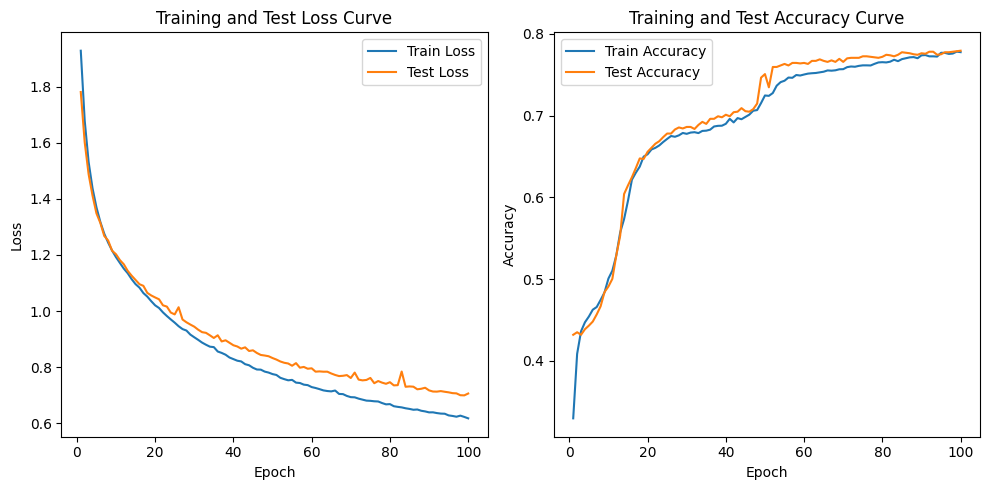

Best accuracy: 0.7793660658794282


In [104]:
loss_fn = nn.CrossEntropyLoss() #Define the loss function
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.00001, momentum=0.9) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies = [] 
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy, train_recall, train_f1= train(train_dataloader, model, loss_fn, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, test_recall, test_f1 = test(test_dataloader, model, loss_fn, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_recalls.append(train_recall) 
  train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  test_recalls.append(test_recall)
  test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Acc {format_metric(train_accuracy)}, Recall {format_metric(train_recall)}, F1 {format_metric(train_f1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Acc {format_metric(test_accuracy)}, Recall {format_metric(test_recall)}, F1 {format_metric(test_f1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l.cpu().numpy() for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")


### ^^ top 15 features

In [105]:
print(xgb_df_5.shape)
exp_dataset = DatasetWrapper(xgb_df_5, target='label') # UPDATE for your experiments

(8044, 6)


In [106]:
# Split training and testing samples

train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 32 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 6435, Test length: 1609


Epoch [ 1/100]       | Train: Loss 1.9625, Acc 0.2855, Recall 0.2855, F1 0.1782          | Test: Loss 1.8457, Acc 0.3132, Recall 0.3132, F1 0.1696
Epoch [ 2/100]       | Train: Loss 1.7693, Acc 0.3779, Recall 0.3779, F1 0.2637          | Test: Loss 1.6986, Acc 0.4009, Recall 0.4009, F1 0.2977
Epoch [ 3/100]       | Train: Loss 1.6544, Acc 0.4292, Recall 0.4292, F1 0.3183          | Test: Loss 1.5881, Acc 0.4661, Recall 0.4661, F1 0.3102
Epoch [ 4/100]       | Train: Loss 1.5612, Acc 0.4347, Recall 0.4347, F1 0.2833          | Test: Loss 1.5062, Acc 0.4612, Recall 0.4612, F1 0.3069
Epoch [ 5/100]       | Train: Loss 1.4969, Acc 0.4301, Recall 0.4301, F1 0.2805          | Test: Loss 1.4495, Acc 0.4574, Recall 0.4574, F1 0.3048
Epoch [ 6/100]       | Train: Loss 1.4469, Acc 0.4246, Recall 0.4246, F1 0.2776          | Test: Loss 1.4055, Acc 0.4624, Recall 0.4624, F1 0.3145
Epoch [ 7/100]       | Train: Loss 1.4102, Acc 0.4328, Recall 0.4328, F1 0.2909          | Test: Loss 1.3689, Acc 0.47

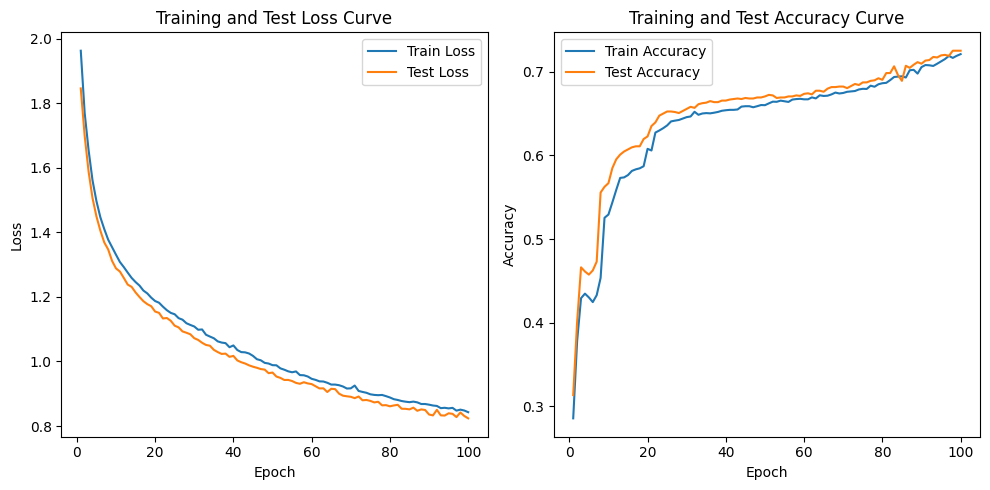

Best accuracy: 0.7252952144188938


In [108]:
model = MLPClassifier(input_size=5, hidden_size=100, num_classes=8)

loss_fn = nn.CrossEntropyLoss() #Define the loss function
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.00001, momentum=0.9) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies = [] 
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy, train_recall, train_f1= train(train_dataloader, model, loss_fn, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, test_recall, test_f1 = test(test_dataloader, model, loss_fn, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_recalls.append(train_recall) 
  train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  test_recalls.append(test_recall)
  test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Acc {format_metric(train_accuracy)}, Recall {format_metric(train_recall)}, F1 {format_metric(train_f1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Acc {format_metric(test_accuracy)}, Recall {format_metric(test_recall)}, F1 {format_metric(test_f1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l.cpu().numpy() for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")


### ^ top 5 results

## 1st Prototype

In [112]:
# Our 1st prototype
top_15 = [
    'label',
    "_Flow_IAT_Std",
    "_Source_Port",
    "_Bwd_IAT_Max",
    "_Flow_Packets/s",
    "_Flow_IAT_Max",
    "_Fwd_IAT_Max",
    "_Active_Max",
    "_Fwd_IAT_Min",
    "Bwd_IAT_Mean",
    "_Destination_Port",
    "_Bwd_IAT_Std",
    "_Bwd_IAT_Min",
    "_Idle_Max",
    "_Fwd_IAT_Std",
    "_Flow_Duration"
]

top_5 = [
    'label',
    "_Flow_IAT_Std",
    "_Source_Port",
    "_Bwd_IAT_Max",
    "_Flow_Packets/s",
    "_Flow_IAT_Max",
    ]

proto1 = df[top_15]
proto1_5 = df[top_5]
proto1.shape

(8044, 16)

In [113]:
exp_dataset = DatasetWrapper(proto1, target='label') # UPDATE for your experiments

In [114]:
# Split training and testing samples

train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

Train length: 6435, Test length: 1609


In [115]:
batch_size = 32 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Epoch [ 1/100]       | Train: Loss 1.8922, Acc 0.4051, Recall 0.4051, F1 0.2915          | Test: Loss 1.7643, Acc 0.4214, Recall 0.4214, F1 0.2764
Epoch [ 2/100]       | Train: Loss 1.6708, Acc 0.4373, Recall 0.4373, F1 0.2905          | Test: Loss 1.5997, Acc 0.4189, Recall 0.4189, F1 0.2751
Epoch [ 3/100]       | Train: Loss 1.5324, Acc 0.4440, Recall 0.4440, F1 0.3040          | Test: Loss 1.4966, Acc 0.4264, Recall 0.4264, F1 0.2884
Epoch [ 4/100]       | Train: Loss 1.4383, Acc 0.4483, Recall 0.4483, F1 0.3139          | Test: Loss 1.4149, Acc 0.4313, Recall 0.4313, F1 0.2941
Epoch [ 5/100]       | Train: Loss 1.3706, Acc 0.4511, Recall 0.4511, F1 0.3203          | Test: Loss 1.3640, Acc 0.4357, Recall 0.4357, F1 0.3039
Epoch [ 6/100]       | Train: Loss 1.3244, Acc 0.4550, Recall 0.4550, F1 0.3292          | Test: Loss 1.3206, Acc 0.4394, Recall 0.4394, F1 0.3117
Epoch [ 7/100]       | Train: Loss 1.2850, Acc 0.4594, Recall 0.4594, F1 0.3367          | Test: Loss 1.2943, Acc 0.44

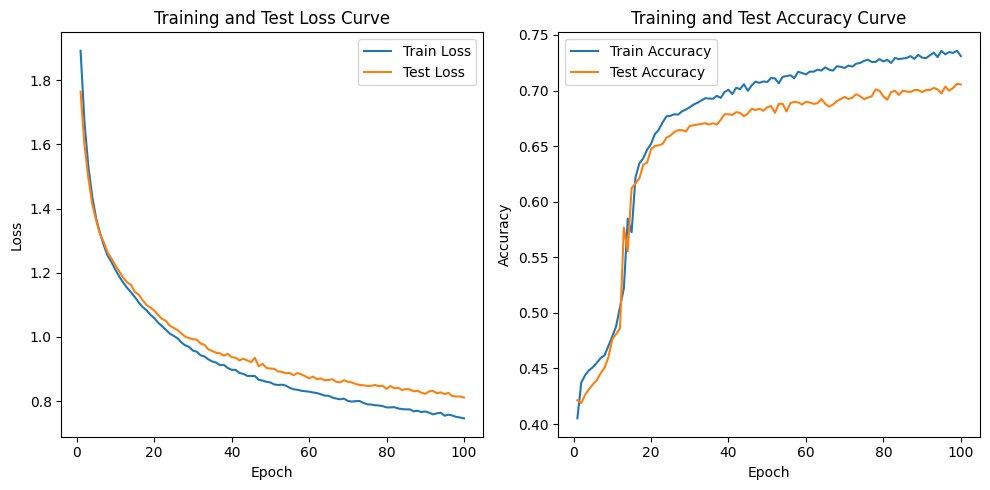

Best accuracy: 0.7060285891858297


In [117]:
model = MLPClassifier(input_size=15, hidden_size=100, num_classes=8)

loss_fn = nn.CrossEntropyLoss() #Define the loss function
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.00001, momentum=0.9) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies = [] 
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy, train_recall, train_f1= train(train_dataloader, model, loss_fn, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, test_recall, test_f1 = test(test_dataloader, model, loss_fn, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_recalls.append(train_recall) 
  train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  test_recalls.append(test_recall)
  test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Acc {format_metric(train_accuracy)}, Recall {format_metric(train_recall)}, F1 {format_metric(train_f1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Acc {format_metric(test_accuracy)}, Recall {format_metric(test_recall)}, F1 {format_metric(test_f1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l.cpu().numpy() for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")


### ^^ top 15 results

In [120]:
print(proto1_5.shape)
exp_dataset = DatasetWrapper(proto1_5, target='label') # UPDATE for your experiments

(8044, 6)


In [121]:
# Split training and testing samples

train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 32 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 6435, Test length: 1609


Epoch [ 1/100]       | Train: Loss 1.9330, Acc 0.2889, Recall 0.2889, F1 0.2145          | Test: Loss 1.7908, Acc 0.3773, Recall 0.3773, F1 0.2505
Epoch [ 2/100]       | Train: Loss 1.7258, Acc 0.3860, Recall 0.3860, F1 0.2520          | Test: Loss 1.6391, Acc 0.3947, Recall 0.3947, F1 0.2620
Epoch [ 3/100]       | Train: Loss 1.6061, Acc 0.3966, Recall 0.3966, F1 0.2594          | Test: Loss 1.5387, Acc 0.4065, Recall 0.4065, F1 0.2731
Epoch [ 4/100]       | Train: Loss 1.5245, Acc 0.4062, Recall 0.4062, F1 0.2693          | Test: Loss 1.4688, Acc 0.4183, Recall 0.4183, F1 0.2858
Epoch [ 5/100]       | Train: Loss 1.4700, Acc 0.4166, Recall 0.4166, F1 0.2834          | Test: Loss 1.4260, Acc 0.4282, Recall 0.4282, F1 0.2959
Epoch [ 6/100]       | Train: Loss 1.4300, Acc 0.4219, Recall 0.4219, F1 0.2910          | Test: Loss 1.3854, Acc 0.4326, Recall 0.4326, F1 0.3007
Epoch [ 7/100]       | Train: Loss 1.3971, Acc 0.4274, Recall 0.4274, F1 0.2964          | Test: Loss 1.3637, Acc 0.43

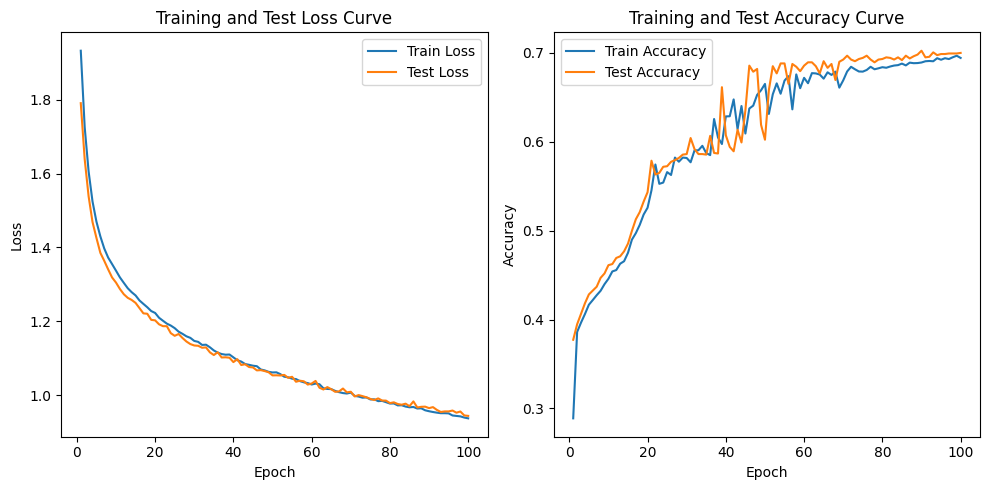

Best accuracy: 0.7022995649471722


In [122]:
model = MLPClassifier(input_size=5, hidden_size=100, num_classes=8)

loss_fn = nn.CrossEntropyLoss() #Define the loss function
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.00001, momentum=0.9) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies = [] 
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy, train_recall, train_f1= train(train_dataloader, model, loss_fn, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, test_recall, test_f1 = test(test_dataloader, model, loss_fn, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_recalls.append(train_recall) 
  train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  test_recalls.append(test_recall)
  test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Acc {format_metric(train_accuracy)}, Recall {format_metric(train_recall)}, F1 {format_metric(train_f1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Acc {format_metric(test_accuracy)}, Recall {format_metric(test_recall)}, F1 {format_metric(test_f1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l.cpu().numpy() for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")


### ^^ top 5 results

From this it appears that the xgboost method ranks features slightly better. This is unfortunate for trying to create a better, attention based, feature ranking method. However, it at least aligns with the results of the models (as in XGBoost preformed better than out first prototype) and more testing is needed with out better preforming models as they produce a different ranking. 

here I will test the more fine tuned model

In [129]:
top_5 = [
    'label',
    '_Source_Port', 
    '_Destination_Port',
    '_Flow_Bytes/s',
    'Fwd_IAT_Mean',
    '_Fwd_IAT_Min',
]

# model for reference 
# TorModel(n_features=26, num_target_classes=8, rff_on=True, pre_norm_on=True, sigma=1.5, embed_size = 10).to(device_in_use)

proto_tuned = df[top_5]


In [130]:
print(proto_tuned.shape)
exp_dataset = DatasetWrapper(proto_tuned, target='label') # UPDATE for your experiments

(8044, 6)


In [131]:
# Split training and testing samples

train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 32 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 6435, Test length: 1609


Epoch [ 1/100]       | Train: Loss 1.8588, Acc 0.3092, Recall 0.3092, F1 0.2248          | Test: Loss 1.7409, Acc 0.3580, Recall 0.3580, F1 0.2408
Epoch [ 2/100]       | Train: Loss 1.6759, Acc 0.3327, Recall 0.3327, F1 0.2188          | Test: Loss 1.6286, Acc 0.3567, Recall 0.3567, F1 0.2350
Epoch [ 3/100]       | Train: Loss 1.5872, Acc 0.3531, Recall 0.3531, F1 0.2343          | Test: Loss 1.5601, Acc 0.4065, Recall 0.4065, F1 0.2806
Epoch [ 4/100]       | Train: Loss 1.5310, Acc 0.4084, Recall 0.4084, F1 0.2923          | Test: Loss 1.5085, Acc 0.4500, Recall 0.4500, F1 0.3565
Epoch [ 5/100]       | Train: Loss 1.4862, Acc 0.4674, Recall 0.4674, F1 0.3761          | Test: Loss 1.4765, Acc 0.5308, Recall 0.5308, F1 0.4429
Epoch [ 6/100]       | Train: Loss 1.4551, Acc 0.5142, Recall 0.5142, F1 0.4330          | Test: Loss 1.4489, Acc 0.5258, Recall 0.5258, F1 0.4408
Epoch [ 7/100]       | Train: Loss 1.4252, Acc 0.5246, Recall 0.5246, F1 0.4400          | Test: Loss 1.4229, Acc 0.53

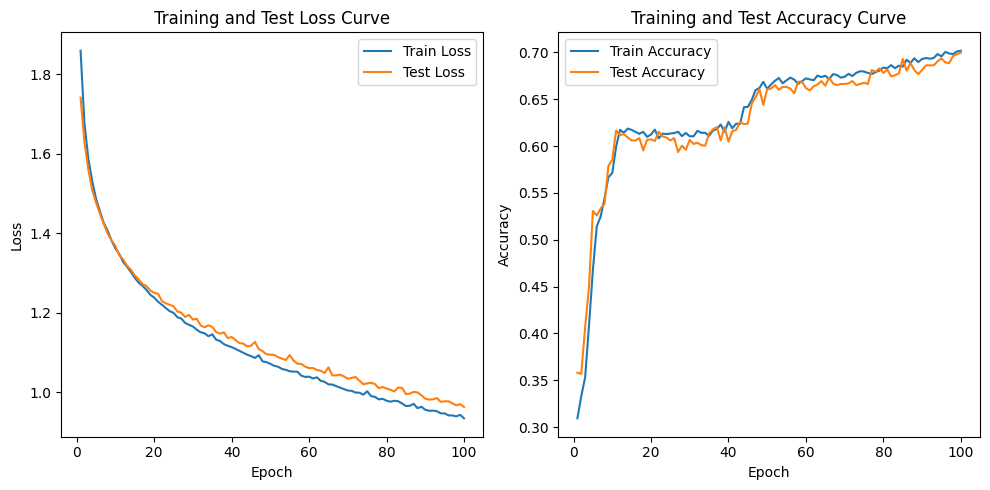

Best accuracy: 0.6998135487880671


In [132]:
model = MLPClassifier(input_size=5, hidden_size=100, num_classes=8)

loss_fn = nn.CrossEntropyLoss() #Define the loss function
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.00001, momentum=0.9) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies = [] 
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy, train_recall, train_f1= train(train_dataloader, model, loss_fn, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, test_recall, test_f1 = test(test_dataloader, model, loss_fn, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_recalls.append(train_recall) 
  train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  test_recalls.append(test_recall)
  test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Acc {format_metric(train_accuracy)}, Recall {format_metric(train_recall)}, F1 {format_metric(train_f1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Acc {format_metric(test_accuracy)}, Recall {format_metric(test_recall)}, F1 {format_metric(test_f1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l.cpu().numpy() for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")


### top 5 scores

XGBoost: Train: **Loss** 0.8430, **Acc** 0.7212, **Recall** 0.7212, F1 0.6951

Proto: Train: **Loss** 0.9369, **Acc** 0.6942, **Recall** 0.6942, F1 0.6604

Proto Tuned: Train: **Loss** 0.9342, **Acc** 0.7018, **Recall** 0.7018, F1 0.6495

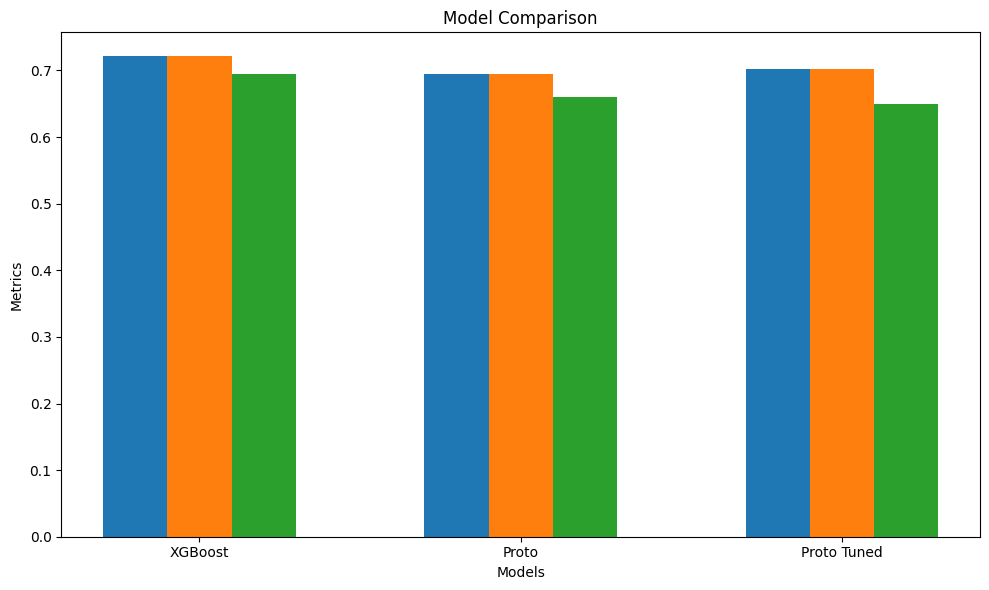

In [134]:
# Data
models = ['XGBoost', 'Proto', 'Proto Tuned']
accuracy = [0.7212, 0.6942, 0.7018]
recall = [0.7212, 0.6942, 0.7018]
f1_score = [0.6951, 0.6604, 0.6495]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data
bar_width = 0.2
x = range(len(models))

ax.bar(x, accuracy, width=bar_width, label='Accuracy')
ax.bar([pos + bar_width for pos in x], recall, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in x], f1_score, width=bar_width, label='F1 Score')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Model Comparison')
ax.set_xticks([pos + bar_width for pos in x])
ax.set_xticklabels(models)

plt.tight_layout()
plt.show()


Unfortunately results do not align as well so we may need to find a more viable way to compare feature ranking. This seems like a very difficult task and I worry about the process of justifying results in the paper. However, this is okay considering the new architecture warrin is working with as the contribution of the next paper is mainly focused on the new multiclass architecture and less on how interpretable it is.